In [2]:
#import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
import plotly.express as px
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline
warnings.filterwarnings('ignore')

**Total Suspended Solids**\
`TSS(mg/L) = W2-Wc / Vol of Sample * 100`

**Calcium Hardness**\
`Calcium Hardness, MgCaCO3 l = (A-B)*c*1000 / volume of Sample`\
`Calcium, mg/l = (A-B)*c*400.8 / volume of sample`\
where:

A is Volume of EDTA used for sample\
B is Volume of EDTA used for blank\
C is mgCaCO3equivalent to 1.00(ml) EDTA solution calcium\
mg/L =0.43 x 1

**Dissolved Oxygen** 

`DO (mg) = (ml titrant)*N*8*1000 / Sample voulme in ml`\
where:

ml titrant is volume of Na2SO2O3 used in titration\
N is Normality of Na2SO2O3\
1000 is Conversion factor to I liter\
8 is Oxidation power of oxygen (mg) equal to 1 milliequivalent of K2Cr2O7


**Chemical Oxygen Demand (COD)**

`COD, mg/L = (A-B) N x 8000 / S`\
where:

A is titer value of the blank\
B is titer value of the sample\
N is normality of the Fe (NH4)2(SO4)2 solution\
S is volume of sample


Water samples were collected from five different coordinates around the dumpsite and were labelled (W1, W2, W3, C1, L1) 

**Data Collection**

Data were carefully collected from the sample taken from identified sample points


In [3]:
#Load data
aquifer_physiochem = pd.read_excel("C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/Aquifer-vulnerability.xlsx", sheet_name=2)
ves_coordinates = pd.read_excel("C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/Aquifer-vulnerability.xlsx", sheet_name=1)

Data analysis strategy,\
perform data cleaning for physiochemical param and ves station\
extraplolate physiochemical params\

for machine learning\
Use clustering algorithm

In [4]:
ves_coordinates 
#drop column unnamed, the clustering will be done along the coordinates

,Unnamed: 0,Station,Elevation (ft),Coordinate East,Coordinate North
0,NaN,1,161/157,6° 47'54.4'',6°06'11.6''
1,NaN,2,146,6°47'59.1'',6°06'53''
2,NaN,3,150,6°48'03.7'',6°06'05.1''
3,NaN,4,162,6°47'55.5'',6°06'14.1''
4,NaN,5,36,6°47'54.14'',6°06'16.7''
5,NaN,6,166,6°47'7.13'',6°06'3.81''
6,NaN,7,163,6°47'7.8'',6°06'2.07''
7,NaN,8,144,6°47'7.84'',6°06'2.12''
8,NaN,9,132,6°47'7.82'',6°06'1.52''
9,NaN,10,156,6°47'1.08'',6°06'1.26''


**Data cleaning for ves coordinate dataframe.**

In [5]:
ves_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        0 non-null      float64
 1   Station           10 non-null     int64  
 2   Elevation (ft)    10 non-null     object 
 3   Coordinate East   10 non-null     object 
 4   Coordinate North  10 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 528.0+ bytes


In [6]:
ves_coordinates = ves_coordinates.drop(columns=['Unnamed: 0'])
ves_coordinates

,Station,Elevation (ft),Coordinate East,Coordinate North
0,1,161/157,6° 47'54.4'',6°06'11.6''
1,2,146,6°47'59.1'',6°06'53''
2,3,150,6°48'03.7'',6°06'05.1''
3,4,162,6°47'55.5'',6°06'14.1''
4,5,36,6°47'54.14'',6°06'16.7''
5,6,166,6°47'7.13'',6°06'3.81''
6,7,163,6°47'7.8'',6°06'2.07''
7,8,144,6°47'7.84'',6°06'2.12''
8,9,132,6°47'7.82'',6°06'1.52''
9,10,156,6°47'1.08'',6°06'1.26''


In [7]:
def dms_to_decimal(dms):
    try:
        pattern = re.compile(r'(\d+)[°\s]+(\d+)[\'\s]+([\d\.])+["\s]*')
        match = pattern.match(dms)
        if match:
            degrees, minutes, seconds = map(float, match.groups())
            decimal_degrees = degrees + minutes/60 + seconds/3600
            return decimal_degrees
        else:
            return None
    except Exception as e:
        print(f"error occured while changing to decimal: {e}")
        raise e

In [8]:
ves_coordinates['Coordinate East'] = ves_coordinates['Coordinate East'].apply(dms_to_decimal)
ves_coordinates['Coordinate North'] = ves_coordinates['Coordinate North'].apply(dms_to_decimal)

ves_coordinates

,Station,Elevation (ft),Coordinate East,Coordinate North
0,1,161/157,6.784444,6.101667
1,2,146,6.783611,6.100833
2,3,150,6.801944,6.100278
3,4,162,6.784722,6.100278
4,5,36,6.784444,6.101944
5,6,166,6.784167,6.100278
6,7,163,6.785556,6.101944
7,8,144,6.784444,6.100556
8,9,132,6.783889,6.100556
9,10,156,6.785556,6.101667


In [9]:
ves_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Station           10 non-null     int64  
 1   Elevation (ft)    10 non-null     object 
 2   Coordinate East   10 non-null     float64
 3   Coordinate North  10 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 448.0+ bytes


In [10]:
def parse_dataframe(elevation):
    try:
        if '/' in str(elevation):
            parts = elevation.split('/')
            return sum(map(int, parts)) // len(parts)
        else:
            return int(elevation)
    except Exception as e:
        print(f"Error while trying to parse the dataframe: {e}")
        raise e

In [11]:
ves_coordinates['Elevation (ft)'] = ves_coordinates['Elevation (ft)'].apply(parse_dataframe)

ves_coordinates

,Station,Elevation (ft),Coordinate East,Coordinate North
0,1,159,6.784444,6.101667
1,2,146,6.783611,6.100833
2,3,150,6.801944,6.100278
3,4,162,6.784722,6.100278
4,5,36,6.784444,6.101944
5,6,166,6.784167,6.100278
6,7,163,6.785556,6.101944
7,8,144,6.784444,6.100556
8,9,132,6.783889,6.100556
9,10,156,6.785556,6.101667


In [12]:
ves_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Station           10 non-null     int64  
 1   Elevation (ft)    10 non-null     int64  
 2   Coordinate East   10 non-null     float64
 3   Coordinate North  10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 448.0 bytes


In [13]:
#save cleaned dataframe
ves_coordinates.to_csv('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/ves_coordinates.csv')

**Data Cleaning**

**Data cleaning for aquifer physiochemical dataframe.**

In [14]:
aquifer_physiochem
#remove unwanted rows and heading.

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S/N,PARAMETERS,W1,W2,W3,C1,L1,Mean,NSDWQ
2,1,pH,5.7,5.2,5.5,5.9,7.1,5.88,6.5-8.5
3,2,Salinity (mg/L),50,45,16,15,1200,265.2,NS
4,3,DO (mg/L),6.4,6.6,6.5,6.5,6.9,6.58,6.5 -8
5,4,BOD5(mg/L),1.12,1.08,1.06,1.03,2.14,1.286,NS
6,5,Chloride (mg/L),18.46,16.15,6.92,6.92,253.83,60.456,100
7,6,Carbonate(mg/L),0,0,0,0,0,0,NS
8,7,Sulphate (mg/L),22,13,0,0,30,13,100
9,8,Magnesium (mg/L),4.115,3.782,2.464,4.439,32.349,9.4298,100


In [15]:
aquifer_physiochem = aquifer_physiochem.rename(columns={'Unnamed: 0':'S/N','Unnamed: 1':'PARAMETERS','Unnamed: 2':'W1',	'Unnamed: 3':'W2','Unnamed: 4':'W3','Unnamed: 5':'C1','Unnamed: 6':'L1','Unnamed: 7':'Mean','Unnamed: 8':'NSDWQ'})

aquifer_physiochem = aquifer_physiochem.drop(index=[0,1])

In [16]:
aquifer_physiochem.reset_index(drop=True, inplace=True)

aquifer_physiochem.drop(columns=['S/N'], inplace=True)

In [17]:
aquifer_physiochem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PARAMETERS  18 non-null     object
 1   W1          18 non-null     object
 2   W2          18 non-null     object
 3   W3          18 non-null     object
 4   C1          18 non-null     object
 5   L1          18 non-null     object
 6   Mean        18 non-null     object
 7   NSDWQ       18 non-null     object
dtypes: object(8)
memory usage: 1.2+ KB


In [18]:
#Identifying uniques values
for col in aquifer_physiochem.select_dtypes(include=['object']).columns:
    print(f"{col}:{aquifer_physiochem[col].unique()}")


PARAMETERS:['pH ' 'Salinity (mg/L) ' 'DO (mg/L)' 'BOD5(mg/L)' 'Chloride (mg/L)'
 'Carbonate(mg/L) ' 'Sulphate (mg/L)' 'Magnesium (mg/L)' 'Calcium (mg/L)'
 'Potassium(mg/L) ' 'Lead (mg/L)' 'Mecury(mg/L) ' 'Chromium(mg/L) '
 'Iron (mg/L)' 'TSS(mg/L)' 'TDS(mg/L)' 'EC(µs/cm)' 'TurbidityN(TU)']
W1:[5.7 50 6.4 1.12 18.46 0 22 4.115 1.571 3.81 '<0.001 ' 'N.D ' 0.339 0.06
 118 230]
W2:[5.2 45 6.6 1.08 16.15 0 13 3.782 0.163 3.089 '<0.001 ' 'N.D ' 0.049 0.12
 77 152]
W3:[5.5 16 6.5 1.06 6.92 0 2.464 '<0.001 ' 0.552 'N.D ' 0.116 0.02 35 68]
C1:[5.9 15 6.5 1.03 6.92 0 4.439 0.215 0.122 '<0.001 ' 'N.D ' 0.187 0.04 27
 46]
L1:[7.1 1200 6.9 2.14 253.83 0 30 32.349 33.386 32.7 0.013 'N.D ' '<0.001 '
 1.299 0.26 1786 3680 29.8]
Mean:[5.88 265.2 6.58 1.286 60.456 0 13 9.4298 8.83375 8.0546 0.013 'N.D' 0.001
 0.398 0.1 408.6 835.2 5.96]
NSDWQ:['6.5-8.5' 'NS' '6.5 -8' 100 150 '1-2' 0.01 'N.D' 0.05 '0.05-0.3  ' 500
 1000 5]


In [19]:
columns_to_clean = ['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']

# iterate and remove non-numeric characters '<' and convert 'N.D' values to NaN
for column in columns_to_clean:
    aquifer_physiochem[column] = pd.to_numeric(aquifer_physiochem[column], errors='coerce')

aquifer_physiochem[columns_to_clean] = aquifer_physiochem[columns_to_clean].astype(float).round(3)

aquifer_physiochem.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PARAMETERS  18 non-null     object 
 1   W1          15 non-null     float64
 2   W2          15 non-null     float64
 3   W3          14 non-null     float64
 4   C1          15 non-null     float64
 5   L1          16 non-null     float64
 6   Mean        17 non-null     float64
 7   NSDWQ       18 non-null     object 
dtypes: float64(6), object(2)
memory usage: 1.2+ KB


In [20]:
#identifying null values
aquifer_physiochem.isna().sum()

PARAMETERS    0
W1            3
W2            3
W3            4
C1            3
L1            2
Mean          1
NSDWQ         0
dtype: int64

In [21]:
#filling null values with mode
modes = aquifer_physiochem[['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']].mode()

aquifer_physiochem[['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']] = aquifer_physiochem[['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']].fillna(modes.iloc[0])

aquifer_physiochem.isna().sum()


PARAMETERS    0
W1            0
W2            0
W3            0
C1            0
L1            0
Mean          0
NSDWQ         0
dtype: int64

In [22]:
aquifer_physiochem

,PARAMETERS,W1,W2,W3,C1,L1,Mean,NSDWQ
0,pH,5.700,5.200,5.500,5.900,7.100,5.880,6.5-8.5
1,Salinity (mg/L),50.000,45.000,16.000,15.000,1200.000,265.200,NS
2,DO (mg/L),6.400,6.600,6.500,6.500,6.900,6.580,6.5 -8
3,BOD5(mg/L),1.120,1.080,1.060,1.030,2.140,1.286,NS
4,Chloride (mg/L),18.460,16.150,6.920,6.920,253.830,60.456,100
5,Carbonate(mg/L),0.000,0.000,0.000,0.000,0.000,0.000,NS
6,Sulphate (mg/L),22.000,13.000,0.000,0.000,30.000,13.000,100
7,Magnesium (mg/L),4.115,3.782,2.464,4.439,32.349,9.430,100
8,Calcium (mg/L),1.571,0.163,0.000,0.215,33.386,8.834,150
9,Potassium(mg/L),3.810,3.089,0.552,0.122,32.700,8.055,1-2


In [23]:
aquifer_physiochem['NSDWQ']

0        6.5-8.5
1             NS
2         6.5 -8
3             NS
4            100
5             NS
6            100
7            100
8            150
9            1-2
10          0.01
11           N.D
12          0.05
13    0.05-0.3  
14            NS
15           500
16          1000
17             5
Name: NSDWQ, dtype: object

In [24]:
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].astype(str)

aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].str.replace(r'\s+', ' ')
 
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].str.replace(',','-')

def convert_to_numeric(value):
    try:
        if "-" in value:
            lower, upper = map(float, value.split('-'))
            return (lower + upper)/2
        elif isinstance(value, str) and value.replace(".", "").isdigit():
            return float(value)
        else:
            return np.nan
        
    except Exception as e:
        print(f"An error occoured: {e}")
        return np.nan
    
    
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].apply(convert_to_numeric)

aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].astype(float)

aquifer_physiochem['NSDWQ']

0        7.500
1          NaN
2        7.250
3          NaN
4      100.000
5          NaN
6      100.000
7      100.000
8      150.000
9        1.500
10       0.010
11         NaN
12       0.050
13       0.175
14         NaN
15     500.000
16    1000.000
17       5.000
Name: NSDWQ, dtype: float64

In [25]:
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].fillna(0)

aquifer_physiochem['NSDWQ']

0        7.500
1        0.000
2        7.250
3        0.000
4      100.000
5        0.000
6      100.000
7      100.000
8      150.000
9        1.500
10       0.010
11       0.000
12       0.050
13       0.175
14       0.000
15     500.000
16    1000.000
17       5.000
Name: NSDWQ, dtype: float64

In [26]:
aquifer_physiochem = aquifer_physiochem.transpose()

new_column_names = {
    0: 'pH',
    1: 'Salinity_(mg/L)',
    2: 'DO_(mg/L)',
    3: 'BODs_(mg/L)',
    4: 'Chloride_(mg/L)',
    5: 'Carbonate_(mg/L)',
    6: 'Sulphate_(mg/L)',
    7: 'Magnesium_(mg/L)',
    8: 'Calcium_(mg/L)',
    9: 'Potassium_(mg/L)',
    10: 'Lead_(mg/L)',
    11: 'Mercury_(mg/L)',
    12: 'Chromium_(mg/L)',
    13: 'Iron_(mg/L)',
    14: 'TSS_(mg/L)',
    15: 'TDS_(mg/L)',
    16: 'EC_(µs/cm)',
    17: 'Turbidity_(TU)',
}

aquifer_physiochem.rename(columns=new_column_names, inplace=True)

aquifer_physiochem = aquifer_physiochem.iloc[1:]

aquifer_physiochem = aquifer_physiochem.astype(float)

print(aquifer_physiochem)

         pH  Salinity_(mg/L)  DO_(mg/L)  BODs_(mg/L)  Chloride_(mg/L)   
W1     5.70             50.0       6.40        1.120           18.460  \
W2     5.20             45.0       6.60        1.080           16.150   
W3     5.50             16.0       6.50        1.060            6.920   
C1     5.90             15.0       6.50        1.030            6.920   
L1     7.10           1200.0       6.90        2.140          253.830   
Mean   5.88            265.2       6.58        1.286           60.456   
NSDWQ  7.50              0.0       7.25        0.000          100.000   

       Carbonate_(mg/L)  Sulphate_(mg/L)  Magnesium_(mg/L)  Calcium_(mg/L)   
W1                  0.0             22.0             4.115           1.571  \
W2                  0.0             13.0             3.782           0.163   
W3                  0.0              0.0             2.464           0.000   
C1                  0.0              0.0             4.439           0.215   
L1                  0.0  

In [27]:
aquifer_physiochem = aquifer_physiochem.drop(index=['Mean','NSDWQ'],).reset_index(drop=True)

aquifer_physiochem

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Mercury_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,5.7,50.0,6.4,1.12,18.46,0.0,22.0,4.115,1.571,3.810,0.000,0.0,0.0,0.339,0.06,118.0,230.0,0.0
1,5.2,45.0,6.6,1.08,16.15,0.0,13.0,3.782,0.163,3.089,0.000,0.0,0.0,0.049,0.12,77.0,152.0,0.0
2,5.5,16.0,6.5,1.06,6.92,0.0,0.0,2.464,0.000,0.552,0.000,0.0,0.0,0.116,0.02,35.0,68.0,0.0
3,5.9,15.0,6.5,1.03,6.92,0.0,0.0,4.439,0.215,0.122,0.000,0.0,0.0,0.187,0.04,27.0,46.0,0.0
4,7.1,1200.0,6.9,2.14,253.83,0.0,30.0,32.349,33.386,32.700,0.013,0.0,0.0,1.299,0.26,1786.0,3680.0,29.8


In [28]:
aquifer_physiochem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                5 non-null      float64
 1   Salinity_(mg/L)   5 non-null      float64
 2   DO_(mg/L)         5 non-null      float64
 3   BODs_(mg/L)       5 non-null      float64
 4   Chloride_(mg/L)   5 non-null      float64
 5   Carbonate_(mg/L)  5 non-null      float64
 6   Sulphate_(mg/L)   5 non-null      float64
 7   Magnesium_(mg/L)  5 non-null      float64
 8   Calcium_(mg/L)    5 non-null      float64
 9   Potassium_(mg/L)  5 non-null      float64
 10  Lead_(mg/L)       5 non-null      float64
 11  Mercury_(mg/L)    5 non-null      float64
 12  Chromium_(mg/L)   5 non-null      float64
 13  Iron_(mg/L)       5 non-null      float64
 14  TSS_(mg/L)        5 non-null      float64
 15  TDS_(mg/L)        5 non-null      float64
 16  EC_(µs/cm)        5 non-null      float64
 17  T

In [29]:
data = aquifer_physiochem.copy()

In [30]:
# #save cleaned dataframe
aquifer_physiochem.to_csv('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/aquifer_physiochem.csv')

In [31]:
aquifer_physiochem.head(7)

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Mercury_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,5.7,50.0,6.4,1.12,18.46,0.0,22.0,4.115,1.571,3.810,0.000,0.0,0.0,0.339,0.06,118.0,230.0,0.0
1,5.2,45.0,6.6,1.08,16.15,0.0,13.0,3.782,0.163,3.089,0.000,0.0,0.0,0.049,0.12,77.0,152.0,0.0
2,5.5,16.0,6.5,1.06,6.92,0.0,0.0,2.464,0.000,0.552,0.000,0.0,0.0,0.116,0.02,35.0,68.0,0.0
3,5.9,15.0,6.5,1.03,6.92,0.0,0.0,4.439,0.215,0.122,0.000,0.0,0.0,0.187,0.04,27.0,46.0,0.0
4,7.1,1200.0,6.9,2.14,253.83,0.0,30.0,32.349,33.386,32.700,0.013,0.0,0.0,1.299,0.26,1786.0,3680.0,29.8


Extraplolating data in aquifer_physiochem dataframe

In [32]:
pH = [5.7, 5.2, 5.5, 5.9, 7.1]
Salinity = [50, 45, 16, 15, 1200, ]
DO = [6.4, 6.6, 6.5, 6.5, 6.9]
BOD = [1.12, 1.08, 1.06, 1.03, 2.14]
chloride = [18.46, 16.15, 6.92, 6.92, 253.83]
Carbonate = [0,0,0,0,0,]
Sulphate = [22,13,0,0,30]
Magnesium = [4.115,3.782,2.464,4.439,32.349,]	
Calcium = [1.571,0.163,0,0.215,33.386]
Potassium = [3.81,3.089,0.552,0.122,32.7]
Lead = [0.001,0.001,0.001,0.001,0.013]
Mecury = [0,0,0,0,0]
Chromium = [0.001,0.001,0.001,0.001,0.001]
Iron = [0.339,0.049,0.116,0.187,1.299]
TSS = [0.06,0.12,0.02,0.04,0.26]
TDS = [118,77,35,27,1786]
EC = [230,152,68,46,3680]
Turbidity = [0,0,0,0,29.8]


In [34]:
# Function to calculate differences
def calculate_differences(data):
    return np.diff(np.array(data))

# Calculating and printing differences
lists = [pH, Salinity, DO, BOD, chloride, Carbonate, Sulphate, Magnesium,
         Calcium, Potassium, Lead, Mecury, Chromium, Iron, TSS, TDS, EC, Turbidity]

list_names = ["pH", "Salinity", "DO", "BOD", "chloride", "Carbonate", "Sulphate", "Magnesium",
              "Calcium", "Potassium", "Lead", "Mercury", "Chromium", "Iron", "TSS", "TDS", "EC", "Turbidity"]

for name, lst in zip(list_names, lists):
    print(f"Differences in {name}: {calculate_differences(lst)}")

Differences in pH: [-0.5  0.3  0.4  1.2]
Differences in Salinity: [  -5  -29   -1 1185]
Differences in DO: [ 0.2 -0.1  0.   0.4]
Differences in BOD: [-0.04 -0.02 -0.03  1.11]
Differences in chloride: [ -2.31  -9.23   0.   246.91]
Differences in Carbonate: [0 0 0 0]
Differences in Sulphate: [ -9 -13   0  30]
Differences in Magnesium: [-0.333 -1.318  1.975 27.91 ]
Differences in Calcium: [-1.408 -0.163  0.215 33.171]
Differences in Potassium: [-0.721 -2.537 -0.43  32.578]
Differences in Lead: [0.    0.    0.    0.012]
Differences in Mercury: [0 0 0 0]
Differences in Chromium: [0. 0. 0. 0.]
Differences in Iron: [-0.29   0.067  0.071  1.112]
Differences in TSS: [ 0.06 -0.1   0.02  0.22]
Differences in TDS: [ -41  -42   -8 1759]
Differences in EC: [ -78  -84  -22 3634]
Differences in Turbidity: [ 0.   0.   0.  29.8]


These values are based on various sources including the World Health Organization (WHO) guidelines, the United States Environmental Protection Agency (EPA) standards, and other environmental quality guidelines.

| Parameter                        | Standard Range              |
|----------------------------------|-----------------------------|
| pH                               | 6.5 - 8.5                   |        
| Salinity                         | < 0.5 ppt                   |
| Dissolved Oxygen (DO)            | 6 - 14 mg/L                 |
| Biochemical Oxygen Demand (BOD)  | < 2 - 6 mg/L                |
| Chloride                         | < 250 mg/L                  |
| Carbonate                        | < 10 mg/L                   |
| Sulfate                          | < 250 mg/L                  |
| Magnesium                        | < 30 mg/L                   |
| Calcium                          | < 75 mg/L                   |
| Potassium                        | < 10 mg/L                   |
| Lead                             | < 0.01 mg/L (10 µg/L)       |
| Mercury                          | < 0.001 mg/L (1 µg/L)       |
| Chromium                         | < 0.05 mg/L (50 µg/L)       |
| Iron                             | < 0.3 mg/L                  |
| Total Suspended Solids (TSS)     | < 30 mg/L                   |
| Total Dissolved Solids (TDS)     | < 500 mg/L                  |
| Electrical Conductivity (EC)     | < 500 µS/cm                 |
| Turbidity                        | < 1 - 5 NTU                 |


In [59]:
import random

# Initial values 
initial_values = {
    "pH": 7.1,
    "Salinity": 3.7,
    "DO": 14,
    "BOD": 6,
    "chloride": 260.04,
    "Carbonate": 10,
    "Sulphate": 260.07,
    "Magnesium": 35.39,
    "Calcium": 79.36,
    "Potassium": 12.7,
    "Lead": 0.01,
    "Mercury": 0.001,  # Corrected spelling
    "Chromium": 0.05,
    "Iron": 1.29,
    "TSS": 32.54,
    "TDS": 678.82,
    "EC": 630.43,
    "Turbidity": 7
}

# Standard ranges (upper limits)
standard_ranges = {
    "pH": 14,
    "Salinity": 65,
    "DO": 40,
    "BOD": 15,
    "chloride": 350,
    "Carbonate": 0.00,
    "Sulphate": 350,
    "Magnesium": 40,
    "Calcium": 90,
    "Potassium": 20,
    "Lead": 0.08,
    "Mercury": 0.00,  # Corrected spelling
    "Chromium": 0.05,
    "Iron": 0.8,
    "TSS": 40,
    "TDS": 600,
    "EC": 700,
    "Turbidity": 25  
}

# Differences dictionary 
differences = {
    "pH": [-0.5, 0.3, 0.4, 1.2],
    "Salinity": [-5, -29, -1, 1185],
    "DO": [0.2, -0.1, 0, 0.4],
    "BOD": [-0.04, -0.02, -0.03, 1.11],
    "chloride": [-2.31, -9.23, 0, 246.91],
    "Carbonate": [0, 0, 0, 0],
    "Sulphate": [-9, -13, 0, 30],
    "Magnesium": [-0.333, -1.318, 1.975, 27.91],
    "Calcium": [-1.408, -0.163, 0.215, 33.171],
    "Potassium": [-0.721, -2.537, -0.43, 32.578],
    "Lead": [0, 0, 0, 0.012],
    "Mercury": [0, 0, 0, 0],  # Corrected spelling
    "Chromium": [0, 0, 0, 0],
    "Iron": [-0.29, 0.067, 0.071, 1.112],
    "TSS": [0.06, -0.1, 0.02, 0.22],
    "TDS": [-41, -42, -8, 1759],
    "EC": [-78, -84, -22, 3634],
    "Turbidity": [0, 0, 0, 29.8]
}

# Number of extrapolations
n_extrapolations = 870

# DataFrame to hold extrapolated data
df_extrapolated = pd.DataFrame([initial_values])

def add_outlier(data, n, sequence):
    for key, diffs in differences.items():
        # Calculate outlier as the sum of the first two differences
        outlier_value = df_extrapolated[key].iloc[-1] + diffs[0] + diffs[1]
        # Enforce upper bound
        outlier_value = min(outlier_value, standard_ranges[key])
        data[key] = outlier_value
    return data

# Perform extrapolation
for i in range(1, n_extrapolations + 1):
    new_data = {}
    for key in initial_values.keys():
        # Generate a random value within the specified bounds
        lower_bound = 0
        upper_bound = standard_ranges[key]
        random_value = random.uniform(lower_bound, upper_bound)
        new_data[key] = random_value
    
    # Add an outlier at n = 7 and every sequence of +7
    if i % 7 == 0:
        new_data = add_outlier(new_data, i, 7)
    
    df_extrapolated = pd.concat([df_extrapolated, pd.DataFrame([new_data])], ignore_index=True)

# Display info about the DataFrame
df_extrapolated.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pH         871 non-null    float64
 1   Salinity   871 non-null    float64
 2   DO         871 non-null    float64
 3   BOD        871 non-null    float64
 4   chloride   871 non-null    float64
 5   Carbonate  871 non-null    float64
 6   Sulphate   871 non-null    float64
 7   Magnesium  871 non-null    float64
 8   Calcium    871 non-null    float64
 9   Potassium  871 non-null    float64
 10  Lead       871 non-null    float64
 11  Mercury    871 non-null    float64
 12  Chromium   871 non-null    float64
 13  Iron       871 non-null    float64
 14  TSS        871 non-null    float64
 15  TDS        871 non-null    float64
 16  EC         871 non-null    float64
 17  Turbidity  871 non-null    float64
dtypes: float64(18)
memory usage: 122.6 KB


In [60]:
print(df_extrapolated.columns,)

Index(['pH', 'Salinity', 'DO', 'BOD', 'chloride', 'Carbonate', 'Sulphate',
       'Magnesium', 'Calcium', 'Potassium', 'Lead', 'Mercury', 'Chromium',
       'Iron', 'TSS', 'TDS', 'EC', 'Turbidity'],
      dtype='object')


In [61]:
#rename the columns
new_column_names = {
    'pH': 'pH',
    'Salinity': 'Salinity_(mg/L)',
    'DO': 'DO_(mg/L)',
    'BOD': 'BODs_(mg/L)',
    'chloride': 'Chloride_(mg/L)',
    'Carbonate': 'Carbonate_(mg/L)',
    'Sulphate': 'Sulphate_(mg/L)',
    'Magnesium': 'Magnesium_(mg/L)',
    'Calcium': 'Calcium_(mg/L)',
    'Potassium': 'Potassium_(mg/L)',
    'Lead': 'Lead_(mg/L)',
    'Mercury': 'Mercury_(mg/L)',
    'Chromium': 'Chromium_(mg/L)',
    'Iron': 'Iron_(mg/L)',
    'TSS': 'TSS_(mg/L)',
    'TDS': 'TDS_(mg/L)',
    'EC': 'EC_(µs/cm)',
    'Turbidity': 'Turbidity_(TU)',
}

df_extrapolated.rename(columns=new_column_names, inplace=True)

In [63]:
df_extrapolated.head()

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Mercury_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,7.100000,3.700000,14.000000,6.000000,260.040000,10.0,260.070000,35.390000,79.360000,12.700000,0.010000,0.001,0.050000,1.290000,32.540000,678.820000,630.430000,7.000000
1,13.908502,10.712574,21.732375,13.747307,6.687248,0.0,167.614752,13.754536,12.386483,10.751463,0.042857,0.000,0.035952,0.688640,25.477146,471.873504,380.423378,3.197675
2,10.754982,55.852593,11.843898,13.047186,280.262262,0.0,276.632047,7.734062,70.117411,14.619531,0.052067,0.000,0.023297,0.709685,30.053151,63.340821,618.412088,12.492473
3,5.343768,25.308112,24.999377,13.868595,328.298066,0.0,262.369375,15.228219,53.431572,11.040118,0.003439,0.000,0.007581,0.654913,24.392318,567.221806,406.340119,8.144831
4,9.197248,1.286523,0.487203,6.864799,13.600900,0.0,48.906496,28.716543,12.323047,10.708269,0.025319,0.000,0.035545,0.152925,9.885988,596.103879,688.829750,6.203377


In [64]:
#data merge

data_merged = pd.concat([data, df_extrapolated], ignore_index=True)
data_merged = data_merged.drop(index=[5],).reset_index(drop=True)

data_merged.head(10)

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU),Carbonate_(mg/L),Mercury_(mg/L)
0,5.7,50.0,6.4,1.12,18.46,22.00,4.115,1.571,3.810,0.000,0.00,0.339,0.06,118.0,230.00,0.0,NaN,NaN
1,5.2,45.0,6.6,1.08,16.15,13.00,3.782,0.163,3.089,0.000,0.00,0.049,0.12,77.0,152.00,0.0,NaN,NaN
2,5.5,16.0,6.5,1.06,6.92,0.00,2.464,0.000,0.552,0.000,0.00,0.116,0.02,35.0,68.00,0.0,NaN,NaN
3,5.9,15.0,6.5,1.03,6.92,0.00,4.439,0.215,0.122,0.000,0.00,0.187,0.04,27.0,46.00,0.0,NaN,NaN
4,7.1,1200.0,6.9,2.14,253.83,30.00,32.349,33.386,32.700,0.013,0.00,1.299,0.26,1786.0,3680.00,29.8,NaN,NaN
5,6.9,0.0,14.1,5.94,248.50,238.07,33.739,77.789,9.442,0.010,0.05,0.800,32.50,558.0,468.43,7.0,NaN,NaN
6,7.3,0.0,14.1,5.91,248.50,238.07,35.714,78.004,9.012,0.010,0.05,0.800,32.52,550.0,446.43,7.0,NaN,NaN
7,8.5,65.0,14.5,7.02,350.00,268.07,40.000,90.000,20.000,0.022,0.05,0.800,32.74,600.0,700.00,25.0,NaN,NaN
8,8.0,60.0,14.7,6.98,347.69,259.07,39.667,88.592,19.279,0.022,0.05,0.510,32.80,559.0,622.00,25.0,NaN,NaN
9,8.3,31.0,14.6,6.96,338.46,246.07,38.349,88.429,16.742,0.022,0.05,0.577,32.70,517.0,538.00,25.0,NaN,NaN


In [65]:
#save the cleaned dataframe
data_merged.to_csv('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/water-quality-dataset.csv')

In [66]:
data = data_merged.copy()

Descriptive Statistics

In [67]:
data.describe()

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU),Carbonate_(mg/L),Mercury_(mg/L)
count,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,1745.000000,871.000000,871.000000
mean,10.302634,36.976251,28.420108,11.241926,256.806843,251.264366,29.875212,66.337906,13.797603,0.059159,0.037415,0.501680,29.674667,416.055010,464.141397,18.729504,0.011481,0.000001
std,4.457151,35.377911,12.603354,4.710861,112.405699,110.867531,12.826008,29.271760,6.110170,0.026397,0.016060,0.233220,12.619077,184.984108,214.883790,8.067248,0.338837,0.000034
min,-0.132293,-33.472503,0.034301,-0.045745,-10.043574,-20.912312,-1.641648,-0.709407,-3.236742,0.000000,0.000000,-0.219772,0.003139,-82.070760,-143.062321,0.000000,0.000000,0.000000
25%,7.011943,26.001996,18.227605,7.841157,171.566570,168.303368,20.890571,43.599168,9.332835,0.038166,0.024709,0.367048,19.649376,279.107613,326.270624,12.710561,0.000000,0.000000
50%,13.300000,31.000000,33.019537,14.222425,338.460000,326.070000,38.349000,88.429000,16.312000,0.077783,0.049759,0.571003,36.324518,509.000000,516.000000,24.742927,0.000000,0.000000
75%,13.800000,60.000000,39.900000,14.940000,347.690000,339.070000,39.667000,88.644000,19.279000,0.080000,0.050000,0.648000,39.920000,559.000000,622.000000,25.000000,0.000000,0.000000
max,14.000000,1200.000000,40.000000,15.000000,350.000000,350.000000,40.000000,90.000000,32.700000,0.080000,0.050000,1.299000,40.000000,1786.000000,3680.000000,29.800000,10.000000,0.001000


**Exploratory Data analysis**

Mapping out the sample locations.

In [51]:
import folium
from folium.plugins import MarkerCluster

In [52]:
map_center = [
    (ves_coordinates['Coordinate North'].mean() + ves_coordinates['Coordinate North'].min()) / 2 , 
    (ves_coordinates['Coordinate East'].mean() + ves_coordinates['Coordinate East'].min()) / 2
    ]

stations_map = folium.Map(location=map_center, zoom_start=12)

marker = MarkerCluster().add_to(stations_map)

for _ , row in ves_coordinates.iterrows():
    folium.Marker([
        row['Coordinate North'], row['Coordinate East']],
        popup=f"Station: {row['Station']}, Elevation:{row['Elevation (ft)']} ft",
        icon=folium.Icon(color='Blue')).add_to(marker)
    
stations_map

In [68]:
#drop redundant cols from the dataset
data.drop(columns=['Mercury_(mg/L)','Carbonate_(mg/L)'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                1745 non-null   float64
 1   Salinity_(mg/L)   1745 non-null   float64
 2   DO_(mg/L)         1745 non-null   float64
 3   BODs_(mg/L)       1745 non-null   float64
 4   Chloride_(mg/L)   1745 non-null   float64
 5   Sulphate_(mg/L)   1745 non-null   float64
 6   Magnesium_(mg/L)  1745 non-null   float64
 7   Calcium_(mg/L)    1745 non-null   float64
 8   Potassium_(mg/L)  1745 non-null   float64
 9   Lead_(mg/L)       1745 non-null   float64
 10  Chromium_(mg/L)   1745 non-null   float64
 11  Iron_(mg/L)       1745 non-null   float64
 12  TSS_(mg/L)        1745 non-null   float64
 13  TDS_(mg/L)        1745 non-null   float64
 14  EC_(µs/cm)        1745 non-null   float64
 15  Turbidity_(TU)    1745 non-null   float64
dtypes: float64(16)
memory usage: 218.2 KB


In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,7))

sns.regplot(x='TDS_(mg/L)' , y='Turbidity_(TU)', data=data, color='Green', ax=ax[0,0])
sns.histplot(y='Magnesium_(mg/L)', x='Turbidity_(TU)',data=data, ax=ax[0,1])
sns.countplot(x='Turbidity_(TU)', hue='BODs_(mg/L)', data=data, ax=ax[1,0])
sns.countplot(x='Salinity_(mg/L)', hue='Chloride_(mg/L)', data=data, ax=ax[1,1])

for axes_row in ax:
    for axes in axes_row:
        if axes is not None:
            axes.set_xticklabels(axes.get_xticklabels(), rotation=0, ha='right')
            axes.set_title(axes.get_title(), fontsize=13)
            
plt.tight_layout()
plt.show()

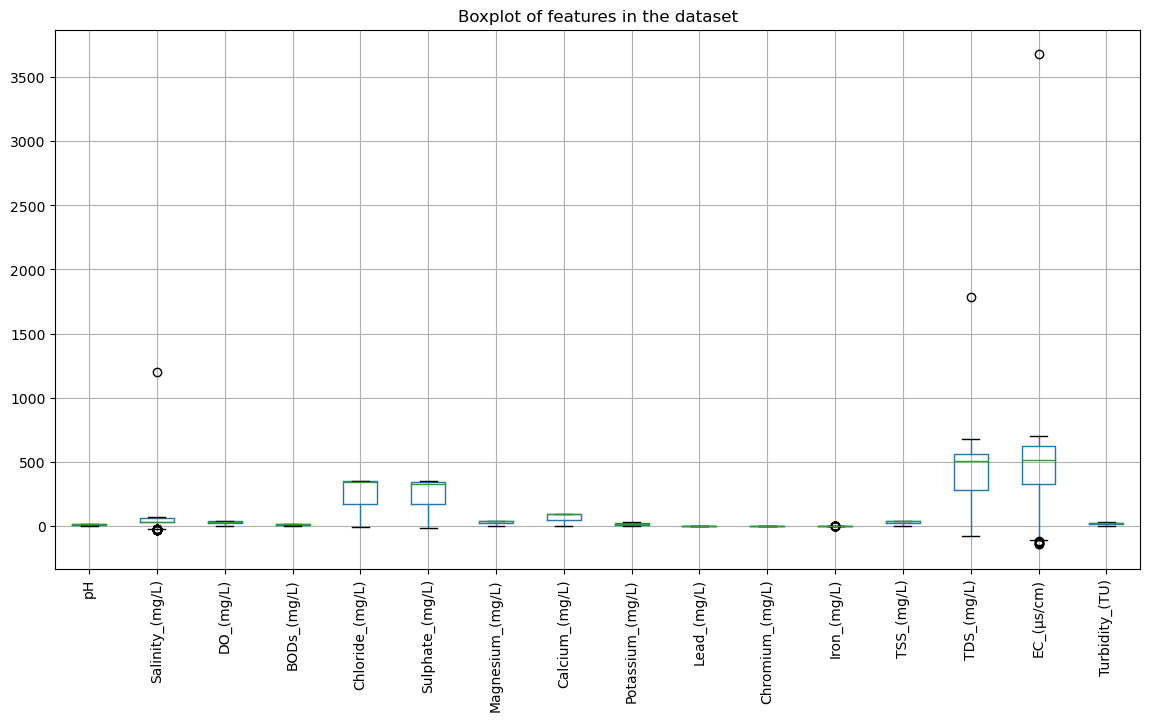

In [72]:

data.boxplot(figsize=(14,7))
plt.title('Boxplot of features in the dataset')
plt.xticks(rotation=90)
plt.show()

Handling Outliers

In [278]:
#Using the quartile range to isolate outliers

# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR =Q3-Q1
# outliers = ((data < (Q1 - 1.5 * IQR))) | (data> (Q3 + 1.5 * IQR)).any(axis=1)

# data = data[~outliers]

# data[:5]

In [73]:
#Using the Z-Score approach to handle outliers

from scipy import stats

z_scores = stats.zscore(data)
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# for col in data.columns:
#     median = data[col].median()
#     data.loc[outliers, col] = median

data = data[~outliers]

data.head()

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,5.7,50.0,6.400000,1.120000,18.46,22.00,4.115,1.571,3.810,0.000000,0.000000,0.339000,0.060000,118.0,230.0,0.000000
1,5.2,45.0,6.600000,1.080000,16.15,13.00,3.782,0.163,3.089,0.000000,0.000000,0.049000,0.120000,77.0,152.0,0.000000
2,5.5,16.0,6.500000,1.060000,6.92,0.00,2.464,0.000,0.552,0.000000,0.000000,0.116000,0.020000,35.0,68.0,0.000000
3,5.9,15.0,6.500000,1.030000,6.92,0.00,4.439,0.215,0.122,0.000000,0.000000,0.187000,0.040000,27.0,46.0,0.000000
4,13.3,31.0,33.019537,14.222425,338.46,326.07,38.349,88.429,16.312,0.077783,0.049759,0.571003,36.324518,509.0,516.0,24.742927


In [74]:
data.isna().sum()

pH                  0
Salinity_(mg/L)     0
DO_(mg/L)           0
BODs_(mg/L)         0
Chloride_(mg/L)     0
Sulphate_(mg/L)     0
Magnesium_(mg/L)    0
Calcium_(mg/L)      0
Potassium_(mg/L)    0
Lead_(mg/L)         0
Chromium_(mg/L)     0
Iron_(mg/L)         0
TSS_(mg/L)          0
TDS_(mg/L)          0
EC_(µs/cm)          0
Turbidity_(TU)      0
dtype: int64

In [75]:
#fill the missing values with their mean.
data = data.fillna(data.mean())

Check for missing values

In [76]:
check_missing = data.isnull().sum() * 100/data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

Correlation plot


In [77]:
correlation = data.corr()
correlation['pH'].sort_values(ascending=False)

pH                  1.000000
Chromium_(mg/L)     0.603894
Turbidity_(TU)      0.602217
TSS_(mg/L)          0.600339
Chloride_(mg/L)     0.590744
Sulphate_(mg/L)     0.588054
BODs_(mg/L)         0.582162
Calcium_(mg/L)      0.568211
Lead_(mg/L)         0.567051
Magnesium_(mg/L)    0.563991
TDS_(mg/L)          0.555977
Potassium_(mg/L)    0.543813
DO_(mg/L)           0.525976
EC_(µs/cm)          0.506142
Iron_(mg/L)         0.465558
Salinity_(mg/L)     0.342390
Name: pH, dtype: float64

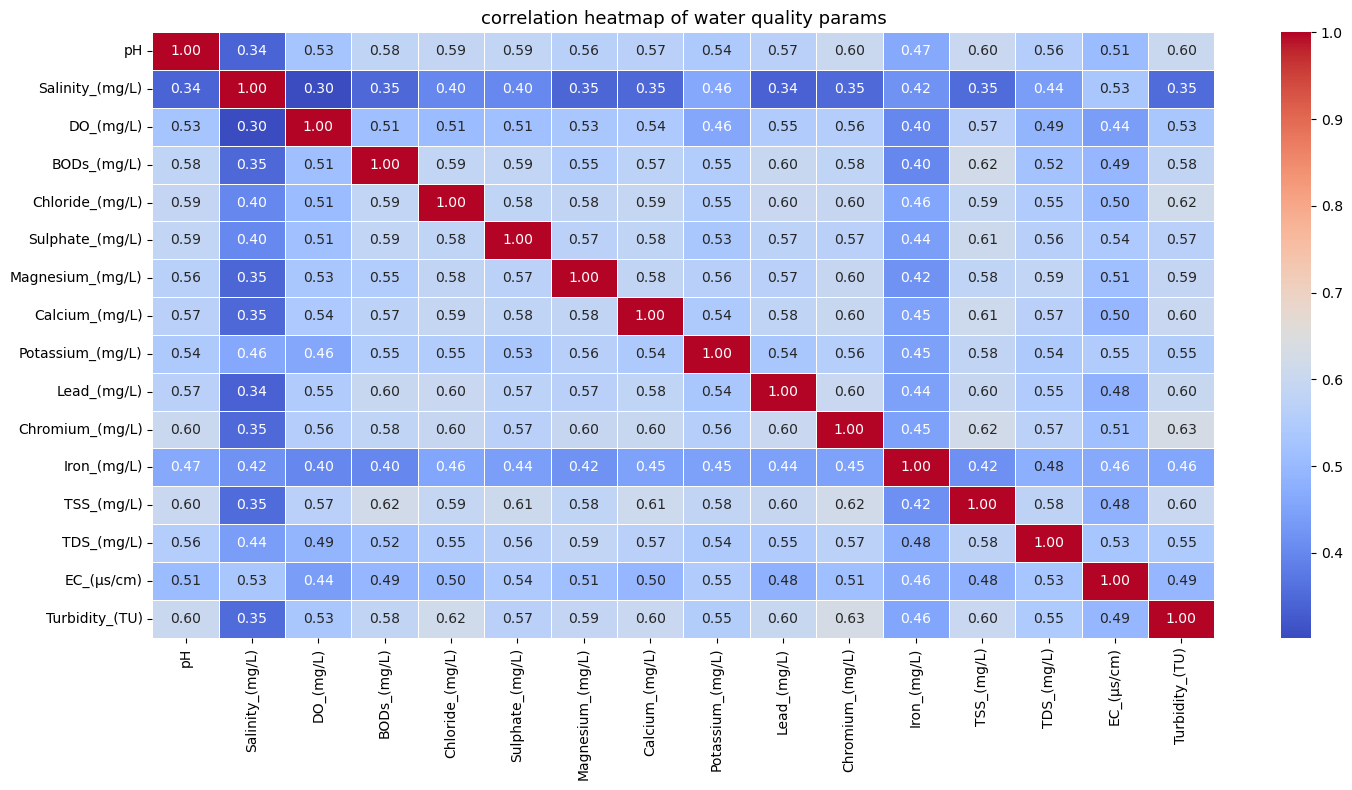

In [78]:
#data.drop(columns=['Carbonate_(mg/L)','Mecury_(mg/L)'], inplace=True)

plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), linewidths=0.5, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('correlation heatmap of water quality params', fontsize=13)

plt.tight_layout()
plt.show()

**Data preprocessing**

In [79]:
#import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')


In [80]:
#standardize the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X_scaled[:5]



,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,-1.034570,0.627779,-1.751709,-2.154307,-2.121215,-2.072211,-2.009037,-2.214706,-1.638215,-2.248262,-2.335408,-0.698797,-2.352631,-1.633858,-1.158337,-2.325164
1,-1.146786,0.398294,-1.735818,-2.162811,-2.141766,-2.153484,-2.035003,-2.262825,-1.756563,-2.248262,-2.335408,-1.950881,-2.347868,-1.859236,-1.547338,-2.325164
2,-1.079457,-0.932716,-1.743763,-2.167062,-2.223878,-2.270879,-2.137773,-2.268396,-2.173000,-2.248262,-2.335408,-1.661606,-2.355806,-2.090111,-1.966262,-2.325164
3,-0.989684,-0.978613,-1.743763,-2.173440,-2.223878,-2.270879,-1.983773,-2.261048,-2.243582,-2.248262,-2.335408,-1.355062,-2.354219,-2.134087,-2.075980,-2.325164
4,0.671108,-0.244263,0.363402,0.631154,0.725573,0.673647,0.660338,0.753722,0.413928,0.703992,0.768121,0.302882,0.526054,0.515479,0.267998,0.745341


In [81]:
X_scaled.shape

(1745, 16)

In [288]:

X = np.array(X_scaled).reshape(-1,1)

X.shape

(12250, 1)

In [289]:
#do this to save memory        
del data, data_merged, aquifer_physiochem

Hyperparameter for cluster algorithm

In [82]:
#model selection for clustering       
model_params = {
    # 'KMeans': {
    #     'model': KMeans(),
    #     'params': {
    #         'n_clusters': list(range(1, 8)),
    #         'init': ['k-means++', 'random'],
    #     },
    #     'scoring': silhouette_score
    # },
    
    'DBSCAN': {
        'model': DBSCAN(),
        'params': {
            'eps': list(np.arange(0.1, 1.0, 0.01)),
            'min_samples': list(range(3, 21))
        },
        'scoring': silhouette_score
    },
    'AgglomerativeClustering': {
        'model': AgglomerativeClustering(),
        'params': {
            'n_clusters': list(range(2, 5)),
            'linkage': ['ward', 'complete', 'average'],
            'metric': ['euclidean']
        },
        'scoring': silhouette_score
    }
}
        
#finding the best cluster estimator
best_estimators = {}
for model_name, params in model_params.items():
    try:
        model = params['model']
        param_grid = params['params']
        scoring = params['scoring']
        
        grid_search = GridSearchCV(model, param_grid, scoring=scoring)
        grid_search.fit(X_scaled)

         
        best_estimators[model_name] = grid_search.best_estimator_
        print(f'Best estimators {model_name}: {grid_search.best_estimator_}')
       
    except Exception as e:
        print(f'Error occured in Hyperparameter tuning {model_name}: {str(e)}')
        
        

Best estimators DBSCAN: DBSCAN(eps=0.1, min_samples=3)
Best estimators AgglomerativeClustering: AgglomerativeClustering(metric='euclidean')


Model development

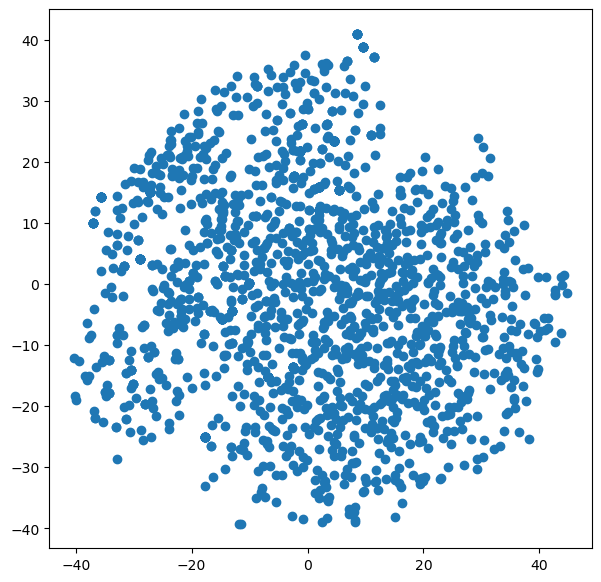

In [86]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=3, random_state=10)
tsne_df = tsne_model.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(tsne_df[:,0], tsne_df[:,1])
plt.show()


In [87]:
error = []

for n_clusters in range(1, 21):
    KM_model = KMeans(init='k-means++', n_clusters=n_clusters, max_iter=500, random_state=42)
    KM_model.fit(X_scaled)
    
    error.append(KM_model.inertia_)

Here inertia is simply the sum of squared distances within the clusters.

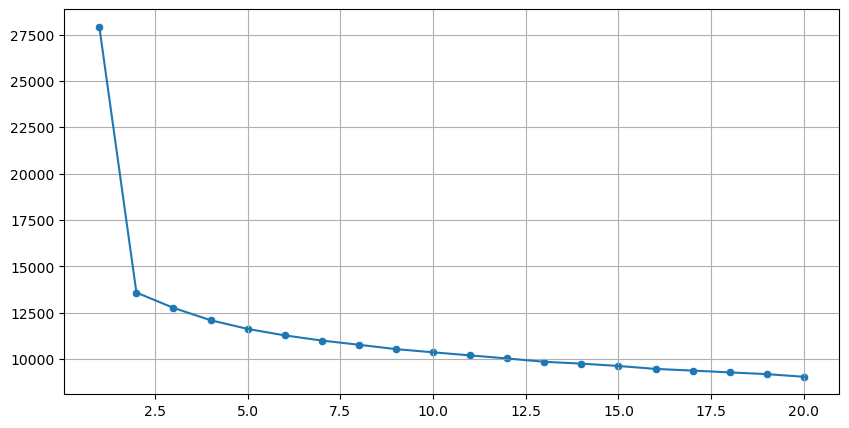

In [88]:
plt.figure(figsize=(10,5))
sns.lineplot(x=range(1,21), y=error)
sns.scatterplot(x=range(1,21), y=error)

plt.grid(True)
plt.show()

Using the elbow method we can ascertain the k = 5, is the optimal number of clusters that should be made as after k= 5, thee value of the inertia is not decreasing drastically.

In [89]:
model = KMeans(init='k-means++', n_clusters=4, max_iter=500, random_state=42)

vulnerability = model.fit_predict(X_scaled)

In [90]:
print(f"Shape of tsne_df: {tsne_df.shape}")
print(f"Length of vulnerability: {len(vulnerability)}")


Shape of tsne_df: (1745, 3)
Length of vulnerability: 1745


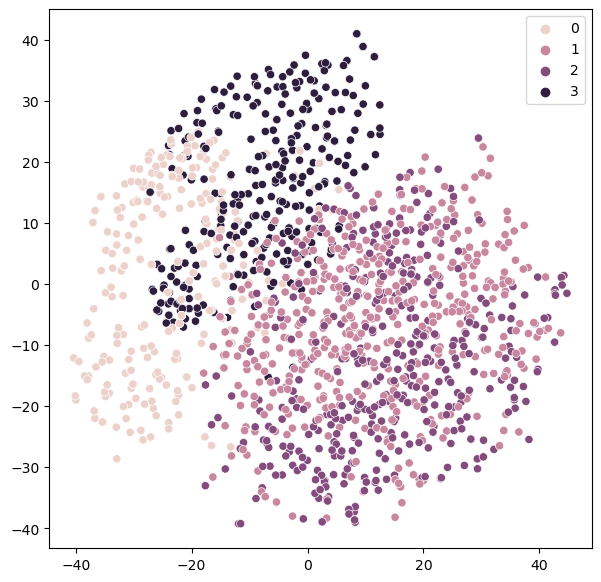

In [91]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=tsne_df[:,0], y=tsne_df[:,1], hue=vulnerability)


plt.show()

NameError: name 'cols' is not defined